# Table of Contents
1. [Exploring the Preprocessed Data](##1.-exploring-the-preprocessed-data)
2. [Feature Selection](##2.-feature-selection)
3. [Anomaly Detection Techniques](##3.-anomaly-detection-techniques)
4. [Model Evaluation](##4.-model-evaluation)
5. [Model Selection](##5.-model-selection)
6. [Analyzing the Detected Anomalies](##6.-analyzing-the-detected-anomalies)
7. [Business Applications for Definity](##7.-business-applications-for-definity)
8. [Threats to Validity](##8.-threats-to-validity)
9. [Next Steps](##9.-next-steps)










This notebook covers anomaly detection. Note that EDA and data cleaning was performed in the vehicle segmentation notebook; hence instead of repeating the same here, the preprocessed data is used directly and insigts from the EDA are applied here where applicable

## Problem Statement
Definity Insurance seeks to enhance underwriting efficiency, optimize pricing strategies, and detect unusual vehicle offers by analyzing car sale data, ultimately improving risk assessment and pricing accuracy across its auto insurance portfolio.

----



## Hypothesis  

Fraudulent or suspicious claims can be identified in a streamlined manner by leveraging anomaly detection techniques. By analyzing vehicle characteristics such as price, engine size, mileage, power, and age, it is possible to detect outliers that deviate significantly from typical market norms.



In [84]:
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn import svm
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


import math



## 1. Exploring the Preprocessed Data

In [85]:
df=pd.read_csv('preprocessed_data.csv')

In [86]:
df.shape

(203936, 19)

In [87]:
df.columns

Index(['Condition', 'Vehicle_brand', 'Vehicle_model', 'Production_year',
       'Mileage_km', 'Power_HP', 'Displacement_cm3', 'Fuel_type', 'Drive',
       'Transmission', 'Type', 'Doors_number', 'Colour', 'First_owner',
       'Offer_publication_date', 'Offer_location', 'Features', 'Price_CAD',
       'Years_From_Production_To_Offer'],
      dtype='object')

In [88]:
df.head()

,Condition,Vehicle_brand,Vehicle_model,Production_year,Mileage_km,Power_HP,Displacement_cm3,Fuel_type,Drive,Transmission,Type,Doors_number,Colour,First_owner,Offer_publication_date,Offer_location,Features,Price_CAD,Years_From_Production_To_Offer
0,New,Abarth,595,2021,1.00,145.00,1400.00,Gasoline,Front wheels,Manual,small_cars,3.00,gray,No,2021-05-04,"ul. Jubilerska 6 - 04-190 Warszawa, Mazowiecki...",[],28006,0
1,Used,Abarth,Other,1974,59000.00,75.00,1100.00,Gasoline,Front wheels,Manual,coupe,2.00,silver,No,2021-05-03,"kanonierska12 - 04-425 Warszawa, Rembertów (Po...",[],14133,47
2,Used,Abarth,500,2018,52000.00,180.00,1368.00,Gasoline,Front wheels,Automatic,small_cars,3.00,silver,No,2021-05-03,"Warszawa, Mazowieckie, Białołęka","['ABS', 'Electric front windows', 'Drivers air...",14588,3
3,Used,Abarth,500,2012,29000.00,160.00,1368.00,Gasoline,Front wheels,Manual,small_cars,3.00,gray,No,2021-04-30,"Jaworzno, Śląskie","['ABS', 'Electric front windows', 'Drivers air...",12964,9
4,New,Abarth,595,2021,600.00,165.00,1368.00,Gasoline,Front wheels,Manual,small_cars,3.00,blue,No,2021-04-30,"ul. Gorzysława 9 - 61-057 Poznań, Nowe Miasto ...","['ABS', 'Electrically adjustable mirrors', 'Pa...",31808,0


In [113]:
df.describe()

,Production_year,Mileage_km,Power_HP,Displacement_cm3,Doors_number,Price_CAD,Years_From_Production_To_Offer
count,203936.00,203936.00,203936.00,203936.00,203936.00,203936.00,203936.00
mean,2012.03,146534.14,151.18,1882.53,4.64,20045.96,8.97
std,6.92,2514212.00,76.47,728.48,0.77,27938.15,6.92
min,1915.00,1.00,1.00,400.00,1.00,190.00,0.00
25%,2008.00,55437.00,105.00,1461.00,5.00,5686.00,4.00
50%,2012.00,145421.00,136.00,1798.00,5.00,11371.00,9.00
75%,2017.00,207000.00,170.00,1997.00,5.00,24335.00,13.00
max,2021.00,1111111111.00,1300.00,8400.00,55.00,2273975.00,106.00


In [89]:
df.isna().sum()

,0
Condition,0
Vehicle_brand,0
Vehicle_model,0
Production_year,0
Mileage_km,0
Power_HP,0
Displacement_cm3,0
Fuel_type,0
Drive,0
Transmission,0


In [90]:
df[df['Price_CAD']==df['Price_CAD'].max()]

,Condition,Vehicle_brand,Vehicle_model,Production_year,Mileage_km,Power_HP,Displacement_cm3,Fuel_type,Drive,Transmission,Type,Doors_number,Colour,First_owner,Offer_publication_date,Offer_location,Features,Price_CAD,Years_From_Production_To_Offer
31371,Used,BMW,X3,2014,238000.00,190.00,2000.00,Diesel,4x4 (permanent),Automatic,SUV,5.00,silver,No,2021-05-04,"ŁYSKOWSKIEGO, 55B - 86-300 Grudziądz, Kujawsko...","['ABS', 'Central locking', 'Electric rear wind...",2273975,7


In [91]:
df.Vehicle_brand.value_counts()

,count
Vehicle_brand,
Volkswagen,18018
BMW,16491
Audi,16303
Opel,16121
Ford,15864
...,...
Tesla,1
Santana,1
Vanderhall,1


## 2. Feature Selection  

Features were selected based on insights from the exploratory data analysis (EDA) and their practical business relevance. The chosen features—'Mileage', 'Power HP', 'Engine Size', 'Price', and 'Car Age'—are key attributes that typically define a car and are collected by insurance organizations. These features often contain many outliers, making it essential to detect anomalies and investigate patterns within them.  

Categorical features that could have provided valuable insights, such as **Brand** and **Condition**, were excluded for specific reasons:  


- **Brand**: Including brand would result in high dimensionality due to the variety of brands in the dataset. Additionally, certain brands are inherently rare in the dataset, which could skew the results and add unnecessary complexity.  
- **Condition**: Most vehicles in the dataset are used, meaning this feature could bias the results by flagging new vehicles as anomalies. Furthermore, 'Car Age' already captures a vehicle's novelty, reducing the necessity of including 'Condition.'  

Taking this into consideration, I thought it prudent to keep it simple while providing actionable insight.


In [92]:
# Selecting features that will be used to detect anomalies
features = ['Mileage_km', 'Power_HP','Displacement_cm3', 'Price_CAD', 'Years_From_Production_To_Offer']
df2=df[features]

## 3. Anomaly Detection Techniques
I selected five techniques for experimentation: Robust Covariance, Isolation Forest, One-Class SVM, Local Outlier Factor, and Z-Score. Each of these methods was evaluated to determine the best-performing algorithm.


In [93]:
# Define anomaly detection algorithms
outliers_fraction = 0.1  # Fraction of anomalies, can be adjusted
th = 1.5  # Threshold for Z-score
n_features = df2.shape[1]  # Use all selected features

In [94]:
# Instantiating the candidate algorithms
anomaly_algorithms = {
    "Robust covariance": EllipticEnvelope(),
    "One-Class SVM": svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1),
    "Isolation Forest": IsolationForest(random_state=42, contamination=outliers_fraction),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction),
    "Z-score": stats.zscore,
}

In [95]:
# Preparing features
X = df2.values
# instante scaler
scaler = MinMaxScaler()
# Scale features
X_scaled = scaler.fit_transform(X)

In [96]:
# This cell may take a long time to run due to the complexity of the operations.

# Loop through each anomaly detection algorithm and apply it to the scaled dataset
for name, algorithm in anomaly_algorithms.items():

    # Handle the specific case for the Local Outlier Factor algorithm
    # The output of `fit_predict` is used to identify anomalies (labelled as -1)
    if name == "Local Outlier Factor":
        y_pred = algorithm.fit_predict(X_scaled) == -1  # Convert anomaly labels to boolean

    # Handle the specific case for Z-score anomaly detection
    # Compute the absolute Z-scores for each feature
    # Identify rows where any feature exceeds the specified threshold `th`
    elif name == "Z-score":
        z_scores = np.abs(stats.zscore(X_scaled, axis=0))  # Compute Z-scores
        y_pred = np.any(z_scores > th, axis=1)  # Identify anomalies as rows with any Z-score > threshold

    # For all other algorithms, fit the model to the scaled data
    # Use the `predict` method to identify anomalies (labelled as -1)
    else:
        y_pred = algorithm.fit(X_scaled).predict(X_scaled) == -1  # Convert anomaly labels to boolean

    # Add the anomaly detection results as a new column to the DataFrame
    # The column is named using the algorithm's name for clarity
    df2[f"Anomaly_{name}"] = y_pred

In [97]:
# This cell may take a very long time to run due to the complexity of the operations.


# Initialize dictionaries to store evaluation metrics for each algorithm
p_values = {}    # To store p-values from the KS test for each feature and algorithm
p_stats_ = {}    # To store KS statistics for each feature and algorithm
percent = {}     # To store the percentage of anomalies detected by each algorithm
silhouette = {}  # To store the mean silhouette score for anomalies detected by each algorithm

# Loop through each anomaly detection algorithm
for name in anomaly_algorithms.keys():

    # Prepare labels for silhouette score calculation
    # Assign 1 for inliers (non-anomalies) and 2 for anomalies to create cluster-like groups
    labels = [1 if x else 2 for x in df2[f"Anomaly_{name}"]]

    # Compute silhouette samples for each data point
    df2[f"Silhouette_{name}"] = silhouette_samples(X_scaled, labels)

    # Calculate and store the average silhouette score for the anomalies
    silhouette[name] = df2[df2[f"Anomaly_{name}"]][f"Silhouette_{name}"].mean()

    # Calculate and store the percentage of anomalies
    dist = df2[f"Anomaly_{name}"].value_counts(normalize=True)
    percent[name] = dist.loc[True]  # Extract the proportion of True (anomalies)

    # Perform Kolmogorov-Smirnov (KS) test to compare feature distributions
    # between anomalies and normal data points
    normal = df2[df2[f"Anomaly_{name}"] == False]  # Subset of normal (non-anomalous) data
    anomaly = df2[df2[f"Anomaly_{name}"] == True]  # Subset of anomalous data

    # Loop through each feature to perform KS test
    for col in features:
        if len(normal) > 0 and len(anomaly) > 0:  # Ensure both groups have data
            stats_, pvalue = stats.kstest(normal[col], anomaly[col])  # Perform KS test

            # Store the KS statistic and p-value for the current feature and algorithm
            p_values[f"{col}_{name}"] = pvalue
            p_stats_[f"{col}_{name}"] = stats_


## 4. Model Evaluation

Anomaly detection in an unsupervised setting presents evaluation challenges as there are no labels to validate the identified anomalies. To address this, I used a combination of statistical tests (Kolmogorov-Smirnov [KS] test), intuition, and silhouette scores to evaluate the performance of various algorithms.

**Silhouette Score**  
The silhouette score measures how well-separated and cohesive the clusters are. In this context, anomalies are treated as one cluster and inliers as another. The score ranges from -1 to 1, where 1 indicates perfect clustering and -1 indicates poor clustering. Higher silhouette scores suggest better-defined separation between anomalies and inliers.

**Kolmogorov-Smirnov (KS) Test**  
The KS test evaluates whether two samples originate from the same distribution. The null hypothesis assumes that the two samples share the same distribution. A low p-value indicates rejection of the null hypothesis, while a higher KS statistic provides stronger evidence that the distributions differ. This makes the KS test a valuable tool for assessing whether anomalies and inliers belong to distinct distributions.

In [98]:
# Initialize lists for features
cols_in = features

# Prepare a dictionary for all metrics
metrics = {
    "Silhouette Score": silhouette,  # silhouette contains the silhouette score
    "Anomaly Percentage": percent,   # percent contains the anomaly percentage values
    "KS P-Values": p_values,         # p_values contains the p-value data
    "KS Statistics": p_stats_,       # p_stats_ contains the KS statistics data
}




## 5. Model Selection
Based on the above-mentioned metrics:  
- Isolation Forest achieved the second-highest silhouette score (trailing only Local Outlier Factor) and a strong KS statistic, indicating distinct distributions for anomalies and inliers.  
- Local Outlier Factor had the highest silhouette score but a significantly lower KS statistic, which made it less favorable.  
- Robust Covariance showed the highest KS statistic but a negative silhouette score, indicating poor clustering quality.  

All algorithms returned sufficiently low p-values, leading to the rejection of the null hypothesis that anomalies and inliers share the same distribution. Considering both the KS statistics and silhouette scores, **Isolation Forest** with contamination set to 0.1 was selected as the optimal algorithm.  A contamination of 0.1 means 10% of all observations in the dataset will be identified as anomalies.

PS. P-values and KS statistics are computed individually for all features, but i decided to take the average of both metrics for simplicity


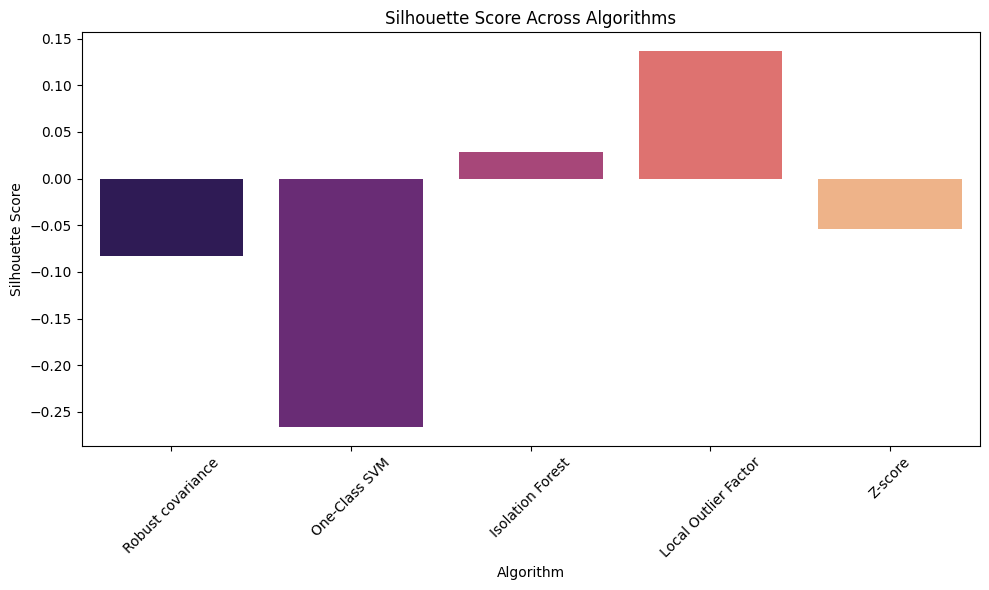

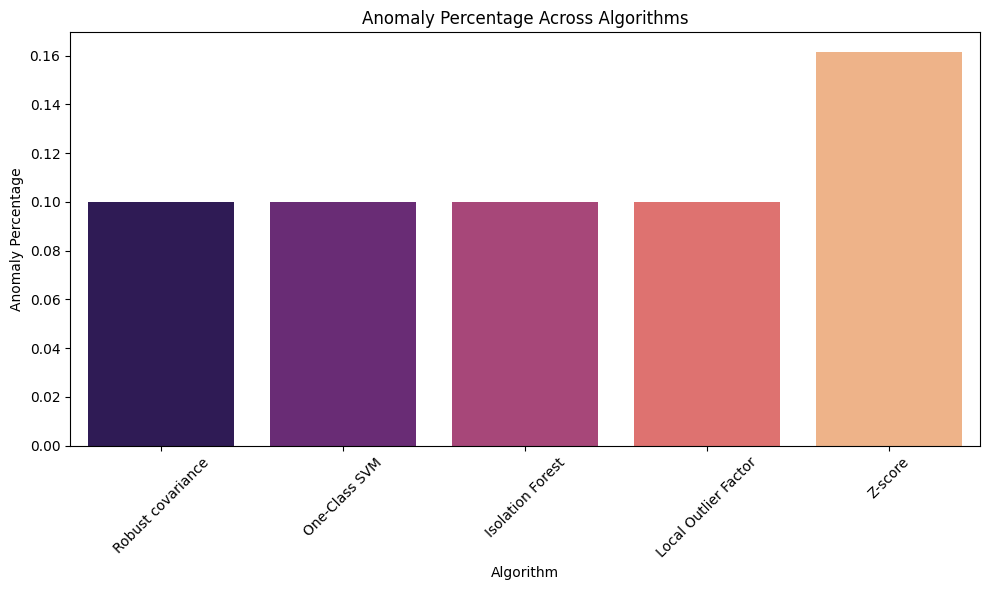

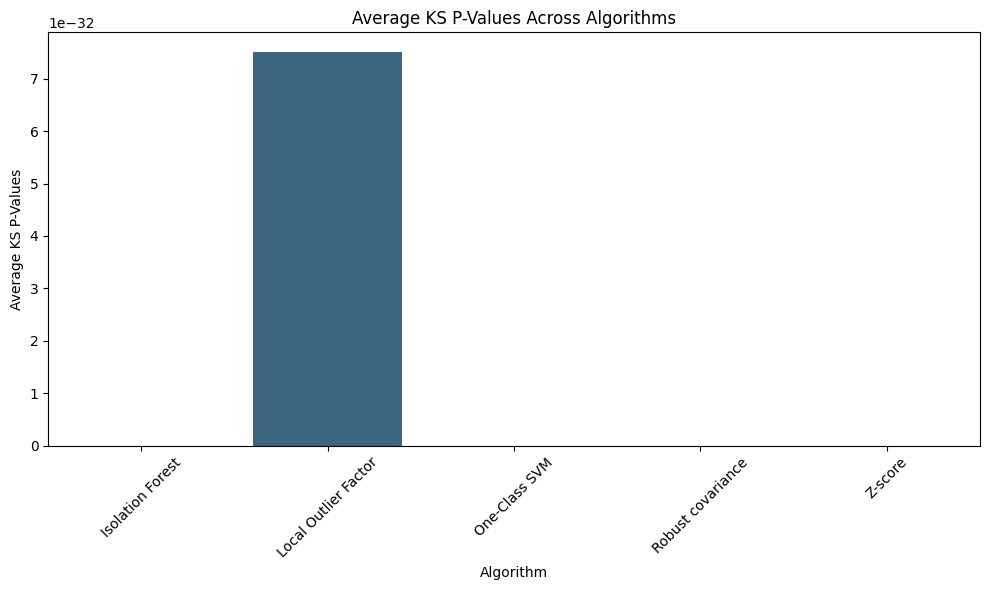

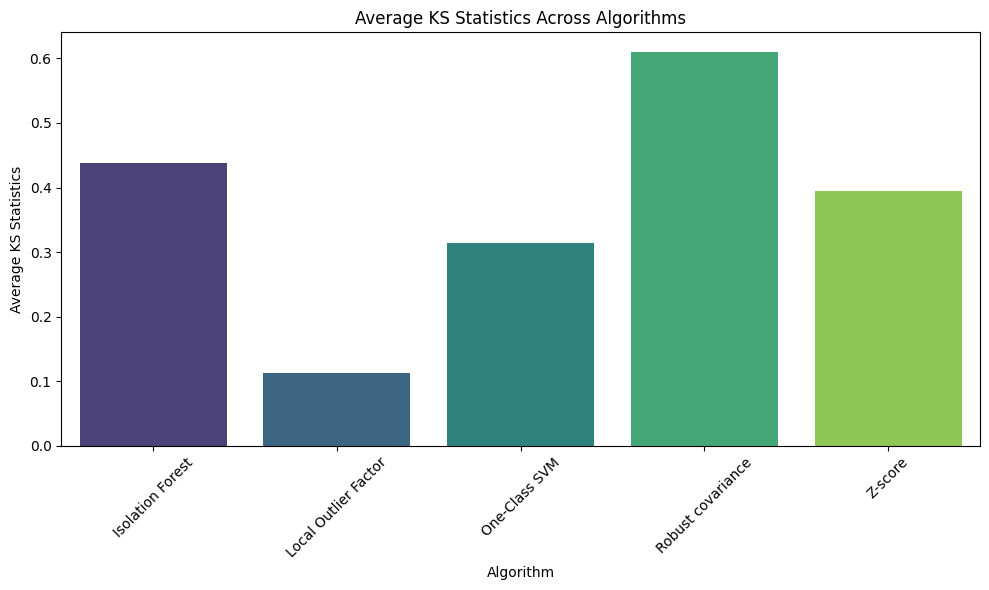

In [99]:
# Visualization: create a separate plot for each metric
for metric_name, metric_data in metrics.items():
    plt.figure(figsize=(10, 6))

    if metric_name in ["KS P-Values", "KS Statistics"]:  # Metrics dependent on features
        # Convert feature-algorithm level data into DataFrame
        metric_df = pd.DataFrame(list(metric_data.items()), columns=["Feature_Algorithm", "Value"])

        # Add a column to indicate the type (Statistic or P-Value)
        metric_df["Type"] = metric_name

        # Function to safely split the last underscore
        def safe_split(key):
            # Split only on the last underscore
            parts = key.rsplit("_", 1)
            if len(parts) == 2:  # Ensure there are exactly two parts
                return parts
            else:
                return [key, "Unknown"]  # Handle cases where the format is invalid

        # Apply the safe split function
        metric_df[["Feature", "Algorithm"]] = metric_df["Feature_Algorithm"].apply(safe_split).apply(pd.Series)

        # Calculate the average value for each algorithm across all features
        avg_metric_df = metric_df.groupby("Algorithm")["Value"].mean().reset_index()

        # Plotting the average metric values across algorithms
        sns.barplot(data=avg_metric_df, x="Algorithm", y="Value", palette="viridis")
        plt.title(f"Average {metric_name} Across Algorithms")
        plt.xlabel("Algorithm")
        plt.ylabel(f"Average {metric_name}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    else:  # For metrics like Silhouette Score and Anomaly Percentage (not dependent on features)
        # Convert algorithm-level data into DataFrame
        metric_df = pd.DataFrame(list(metric_data.items()), columns=["Algorithm", "Value"])

        # Plotting the average metric values across algorithms
        sns.barplot(data=metric_df, x="Algorithm", y="Value", palette="magma")
        plt.title(f"{metric_name} Across Algorithms")
        plt.xlabel("Algorithm")
        plt.ylabel(f"{metric_name}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


In [100]:
# view column names including the ones that hold the difference metrics
df2.columns

Index(['Mileage_km', 'Power_HP', 'Displacement_cm3', 'Price_CAD',
       'Years_From_Production_To_Offer', 'Anomaly_Robust covariance',
       'Anomaly_One-Class SVM', 'Anomaly_Isolation Forest',
       'Anomaly_Local Outlier Factor', 'Anomaly_Z-score',
       'Silhouette_Robust covariance', 'Silhouette_One-Class SVM',
       'Silhouette_Isolation Forest', 'Silhouette_Local Outlier Factor',
       'Silhouette_Z-score'],
      dtype='object')

In [101]:
# View the dataframe including metrics and anomaly flags
df2.head()

,Mileage_km,Power_HP,Displacement_cm3,Price_CAD,Years_From_Production_To_Offer,Anomaly_Robust covariance,Anomaly_One-Class SVM,Anomaly_Isolation Forest,Anomaly_Local Outlier Factor,Anomaly_Z-score,Silhouette_Robust covariance,Silhouette_One-Class SVM,Silhouette_Isolation Forest,Silhouette_Local Outlier Factor,Silhouette_Z-score
0,1.00,145.00,1400.00,28006,0,False,False,False,True,False,0.50,0.53,0.66,0.09,0.62
1,59000.00,75.00,1100.00,14133,47,True,True,True,False,True,-0.25,-0.17,-0.22,-0.05,-0.16
2,52000.00,180.00,1368.00,14588,3,False,False,False,False,False,0.51,0.56,0.67,-0.10,0.62
3,29000.00,160.00,1368.00,12964,9,False,False,False,False,False,0.62,0.62,0.71,-0.18,0.67
4,600.00,165.00,1368.00,31808,0,False,False,False,True,False,0.47,0.52,0.65,0.08,0.60


In [102]:
# List of all feature columns and isolation forest anomaly column
columns_to_keep = ['Mileage_km', 'Power_HP', 'Displacement_cm3', 'Price_CAD',
                   'Years_From_Production_To_Offer', 'Anomaly_Isolation Forest']

# Filter the DataFrame to only keep the specified columns
df_filtered = df2[columns_to_keep]

# Display the filtered DataFrame
df_filtered


,Mileage_km,Power_HP,Displacement_cm3,Price_CAD,Years_From_Production_To_Offer,Anomaly_Isolation Forest
0,1.00,145.00,1400.00,28006,0,False
1,59000.00,75.00,1100.00,14133,47,True
2,52000.00,180.00,1368.00,14588,3,False
3,29000.00,160.00,1368.00,12964,9,False
4,600.00,165.00,1368.00,31808,0,False
...,...,...,...,...,...,...
203931,40000.00,173.00,1301.00,12964,7,False
203932,63518.00,70.00,2120.00,3541,51,True
203933,11880.00,60.00,2120.00,2242,44,True
203934,100000.00,36.00,2200.00,1852,35,True


## 6. Analyzing the Detected Anomalies

As previously discussed, the selected features are critical for defining vehicles, making it essential to assess how these features differ between anomalies and normal (inliers). To facilitate this analysis, descriptive statistics and distributions for each feature were calculated and plotted side by side for inliers and anomalies. Below is a high-level comparison of the patterns observed in each feature, supported by examples:

### **Price (CAD)**
- Anomalous vehicles tend to have extremely high prices, pulling the mean price upward compared to inliers. For example, while most inliers fall below 100.5k CAD, anomalies include prices as high as 2.73M CAD. These patterns suggest that anomalies are effectively capturing luxury or rare vehicles with atypical price points. Although there is some overlap in price distributions between anomalies and inliers, the significantly higher outliers in anomalies validate their classification.

### **Engine Size (Displacement_cm3)**
- Larger engine sizes, often exceeding 3.25L and reaching up to 8.4L, dominate the anomalous vehicles. These may represent bigger trucks or high-performance vehicles, which stand out compared to the smaller engine sizes typical of inliers.
- Engine sizes for inliers are more modest, with the majority clustering around 1.73L. Rarely do they exceed 4.02L, reinforcing their distinction from anomalies.

### **Power (HP)**
- Anomalous vehicles frequently exhibit high horsepower, often exceeding 1,300 HP. Such cars, likely luxury or sports models, significantly deviate from the norm and may pose potential risks or considerations for insurance purposes.
- In contrast, most inliers feature horsepower levels around 136 HP, with a maximum of 340 HP, reflecting more conventional cars.

### **Mileage (km)**
- Anomalous vehicle often present either extremely low or unreasonably high values for their mileages, such as over a billion km, most likely indicating either data errors or suspicious claims. This variability skews the average for anomalies.
- Mileage for inliers is far more consistent, typically ranging from moderate to high values but rarely exceeding 2.93M km.

### **Age (Years From Production to Offer)**
- Anomalous vehicles are either extremely old or notably new, with ages ranging from 0 to over 100 years. These may represent vintage cars or newly released models, or simply suspicious or fraudulent claims.
- Inlier vehicles are predominantly within a typical age range of up to 32 years, making them more representative of standard market offerings.

---

Across all features, vehicles that deviate significantly from market norms are detected as anomalous. These vehicles may include luxury models, rare collectibles, or entries with potential data inconsistencies or suspicious offers. This highlights their potential as candidates for further investigation. While some overlap exists, the model successfully identified anomalies, providing valuable insights for probing and decision-making.

See tables below for side by side comparison

### Summary Tables

#### Anomalies
| Feature                        | Mean      | Std Dev   | Median   | Min   | Max          |
|--------------------------------|-----------|-----------|----------|-------|--------------|
| Mileage (km)                   | 204,455.95 | 7,945,569.33 | 91,000.00 | 1.00  | 1,111,111,111.00 |
| Power (HP)                     | 291.99     | 135.22    | 292.00   | 1.00  | 1,300.00     |
| Engine Size (Displacement_cm3) | 3,254.33   | 1,257.29  | 2,993.00 | 400.00| 8,400.00     |
| Price (CAD)                    | 55,512.87  | 65,629.16 | 32,165.00| 211.00| 2,273,975.00 |
| Age (Years)                    | 12.29      | 13.33     | 8.00     | 0.00  | 106.00       |

#### Inliers
| Feature                        | Mean      | Std Dev   | Median   | Min   | Max         |
|--------------------------------|-----------|-----------|----------|-------|-------------|
| Mileage (km)                   | 140,098.25| 93,314.31 | 149,035.00| 1.00  | 2,930,000.00|
| Power (HP)                     | 135.54    | 44.92     | 130.00   | 1.00  | 340.00      |
| Engine Size (Displacement_cm3) | 1,730.11  | 426.24    | 1,685.00 | 400.00| 4,015.00    |
| Price (CAD)                    | 16,105.11 | 15,277.50 | 10,689.00| 190.00| 100,426.00  |
| Age (Years)                    | 8.60      | 5.66      | 9.00     | 0.00  | 32.00       |


In [103]:
# Set pandas options to avoid scientific notation
pd.set_option('display.float_format', '{:.2f}'.format)

# Split the DataFrame into anomalies (True) and inliers (False)
anomalies = df2[df2['Anomaly_Isolation Forest'] == True]
inliers = df2[df2['Anomaly_Isolation Forest'] == False]

# Initialize dictionaries to store summary statistics for anomalies and inliers
anomaly_stats = {}
inlier_stats = {}

# List of feature columns to compare
feature_columns = ['Mileage_km', 'Power_HP', 'Displacement_cm3', 'Price_CAD', 'Years_From_Production_To_Offer']

# Calculate summary statistics (mean, std, median, min, max) for anomalies and inliers
for feature in feature_columns:
    anomaly_description = anomalies[feature].describe()
    inlier_description = inliers[feature].describe()

    # Store the results separately for anomalies and inliers
    anomaly_stats[feature] = {
        "Mean": anomaly_description["mean"],
        "Std": anomaly_description["std"],
        "Median": anomaly_description["50%"],
        "Min": anomaly_description["min"],
        "Max": anomaly_description["max"]
    }
    inlier_stats[feature] = {
        "Mean": inlier_description["mean"],
        "Std": inlier_description["std"],
        "Median": inlier_description["50%"],
        "Min": inlier_description["min"],
        "Max": inlier_description["max"]
    }

# Convert the dictionaries into DataFrames for easier visualization
anomaly_df = pd.DataFrame(anomaly_stats)
inlier_df = pd.DataFrame(inlier_stats)

In [104]:
anomaly_df

,Mileage_km,Power_HP,Displacement_cm3,Price_CAD,Years_From_Production_To_Offer
Mean,204455.95,291.99,3254.33,55512.87,12.29
Std,7945569.33,135.22,1257.29,65629.16,13.33
Median,91000.00,292.00,2993.00,32165.00,8.00
Min,1.00,1.00,400.00,211.00,0.00
Max,1111111111.00,1300.00,8400.00,2273975.00,106.00


In [105]:
inlier_df

,Mileage_km,Power_HP,Displacement_cm3,Price_CAD,Years_From_Production_To_Offer
Mean,140098.25,135.54,1730.11,16105.11,8.60
Std,93314.31,44.92,426.24,15277.50,5.66
Median,149035.00,130.00,1685.00,10689.00,9.00
Min,1.00,1.00,400.00,190.00,0.00
Max,2930000.00,340.00,4015.00,100426.00,32.00


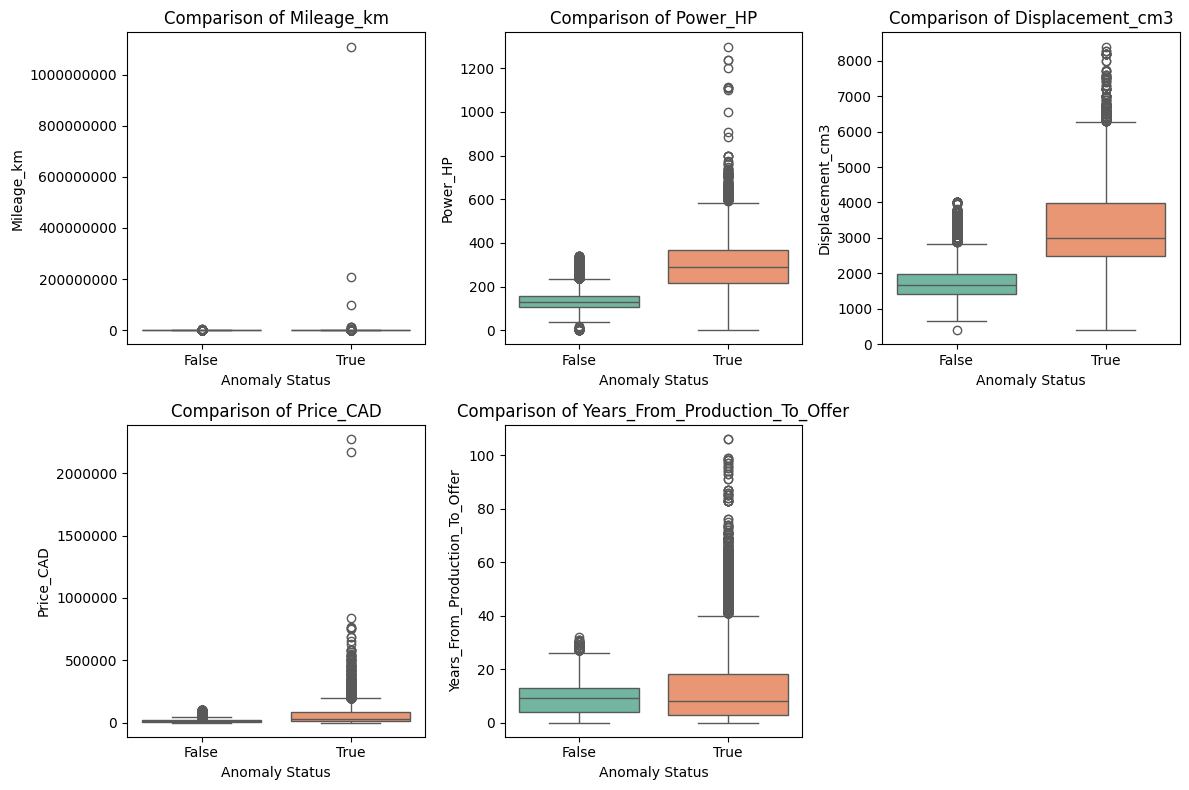

In [106]:
# Visualize comparisons using boxplots
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Anomaly_Isolation Forest', y=feature, data=df2, palette='Set2')
    plt.title(f"Comparison of {feature}", fontsize=12)
    plt.xlabel("Anomaly Status")
    plt.ylabel(feature)
    plt.ticklabel_format(style='plain', axis='y')  # Avoid scientific notation on y-axis

plt.tight_layout()
plt.show()


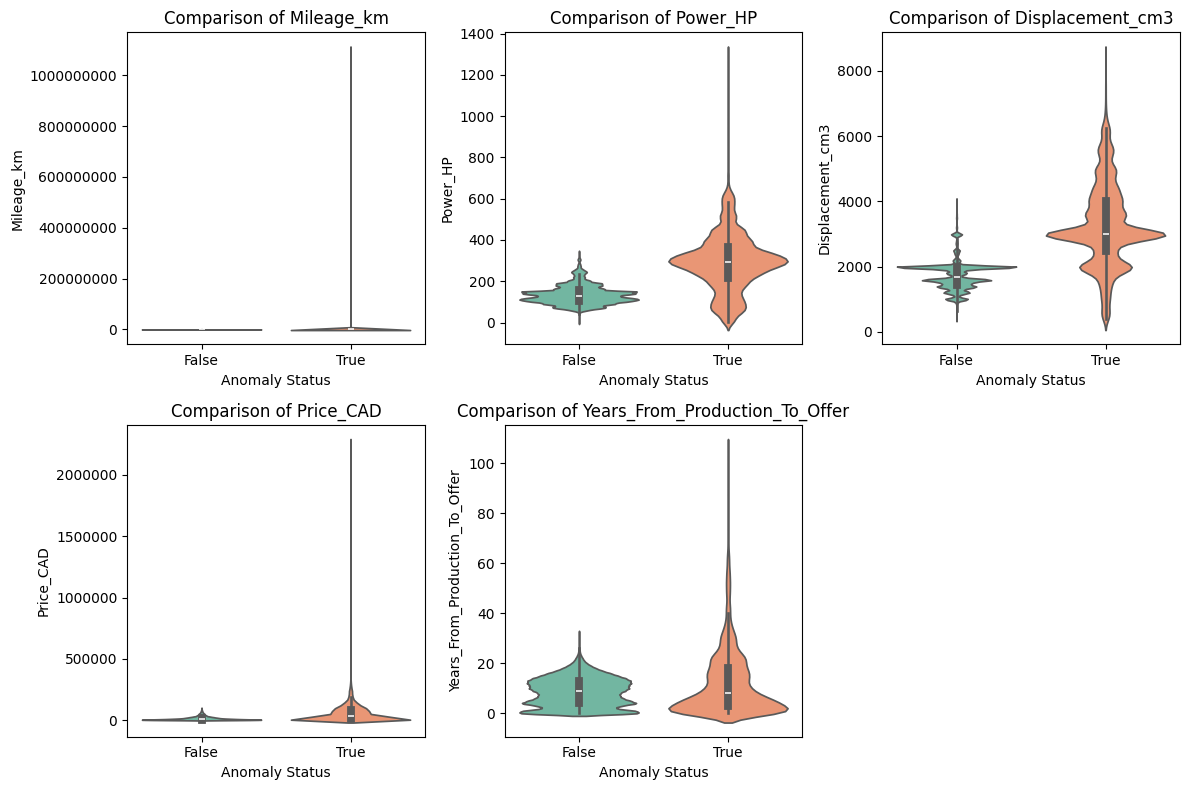

In [107]:
# Visualize comparisons using violin plots
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.violinplot(x='Anomaly_Isolation Forest', y=feature, data=df2, palette='Set2')
    plt.title(f"Comparison of {feature}", fontsize=12)
    plt.xlabel("Anomaly Status")
    plt.ylabel(feature)
    plt.ticklabel_format(style='plain', axis='y')  # Avoid scientific notation on y-axis

plt.tight_layout()
plt.show()


In [108]:
# Select the feature columns for t-SNE
X_tsne = df2[features]

In [109]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
tsne_results = tsne.fit_transform(X_tsne)


In [110]:
# Add the t-SNE results to the DataFrame
df2['TSNE-1'] = tsne_results[:, 0]
df2['TSNE-2'] = tsne_results[:, 1]

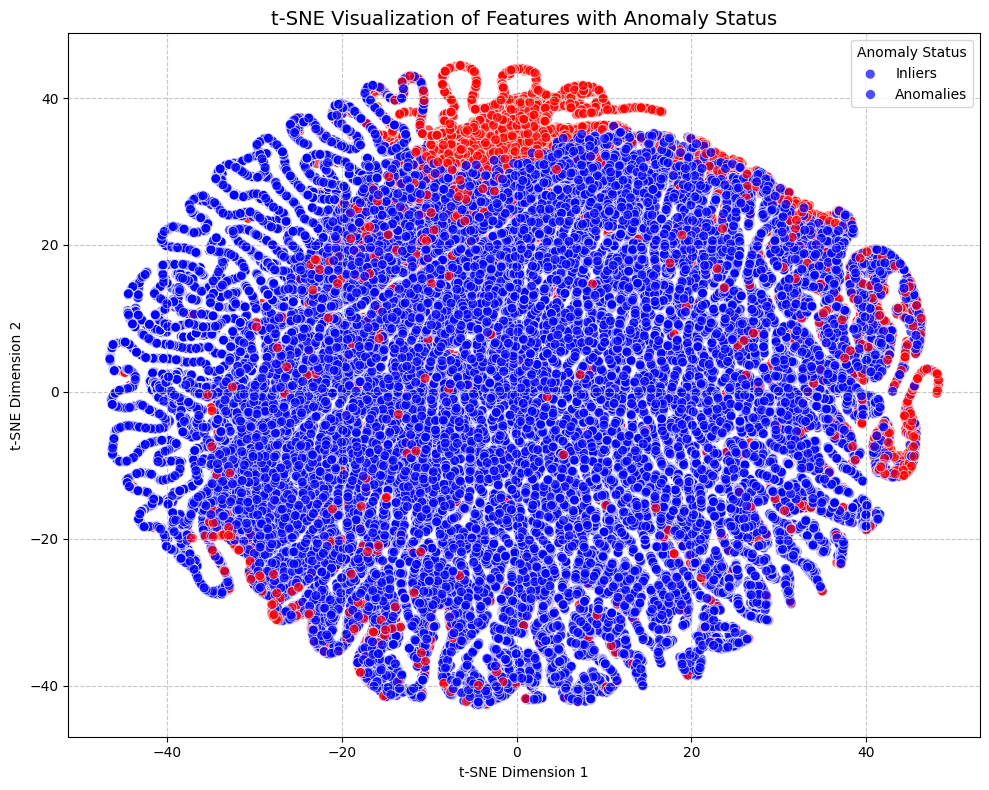

In [111]:
# Plot t-SNE results with anomalies highlighted
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='TSNE-1',
    y='TSNE-2',
    hue='Anomaly_Isolation Forest',
    data=df2,
    palette={False: 'blue', True: 'red'},
    alpha=0.7,
    s=50
)
plt.title("t-SNE Visualization of Features with Anomaly Status", fontsize=14)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Anomaly Status", labels=["Inliers", "Anomalies"])
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## 7. Business Applications for Definity

**1. Risk Assessment and Fraud Detection**  
Identifying unusual patterns or anomalies in vehicle features such as Price (CAD), Mileage (km), and Age will enable Definity Insurance to assess the risk profiles of vehicles more accurately. For example, a car with extremely low mileage for its age could indicate a history of accidents and repairs or odometer tampering, suggesting elevated risk. By identifying such anomalies, Definity can refine its pricing models to offer customized premiums based on a vehicle’s true condition rather than relying solely on standard parameters like make and model.  

**2. Preventing Overinsurance and Underinsurance**  
Detecting anomalies in vehicle prices helps Definity flag cases of potential overinsurance or underinsurance. A car priced significantly higher than its market value might indicate overinsurance, while a vehicle priced unusually low could be underinsured. Accurate anomaly detection ensures vehicles are insured at appropriate levels, protecting both the company and policyholders from financial discrepancies.  

**3. Automated Underwriting**  
The anomaly detection model can be integrated into the underwriting process to flag vehicles that deviate from typical patterns, requiring additional scrutiny or manual review. This streamlines underwriting by allowing straightforward cases to be approved quickly while ensuring complex or risky cases are examined thoroughly. This approach reduces operational costs and enhances the customer experience by expediting policy issuance.  

---

## 8. Threats to Validity

As mentioned above, evaluating the model may be somewhat subjective. Although the model is able to identify anomalies, there is a risk of misclassifying normal vehicles as anomalies. Therefore, further investigation is required for any detected anomalies. Another potential threat lies in the selected features; perhaps a different combination of features could provide more definitive results. Additionally, some overlap in the distribution of features between inliers and anomalies should be taken into account.


## 9. Next Steps

Although I have experimented with different algorithms and adjusted the contamination level for the Isolation Forest, I would like to explore other methods, such as DBSCAN, and experiment with additional contamination levels. Furthermore, obtaining labels for the identified anomalies from historical data could enhance the evaluation process. This will enable a more robust evaluation strategy, such as calculating the F1 score, to better assess the model's performance.